In [48]:
import matplotlib.pyplot as plt 
import numpy as np
from util.functions import get_data_ticker, dias_uteis_entre_datas, decompor_sinal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [49]:
# Define as constantes
EMPRESA = 'PETR4.SA'
SEED = 42
periodo = '5y'
janela_movel = 1

## Obter dados

In [50]:
dados_historicos = get_data_ticker(EMPRESA, period='5y')
dados_historicos.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [51]:

# Separa os dados em características e variável alvo
df = dados_historicos.drop('tomorrow', axis=1)
alvo = dados_historicos['tomorrow']

In [52]:

# Divide os dados em conjuntos de treinamento e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(df, alvo, test_size = 0.20, random_state=42)

# Cria o modelo Random Forest
modelo = RandomForestRegressor(n_estimators=100, random_state=42)
y_treino = y_treino.dropna()


In [53]:
# Treina o modelo
modelo.fit(X_treino, y_treino)

# Faz previsões no conjunto de teste
previsoes = modelo.predict(X_teste)

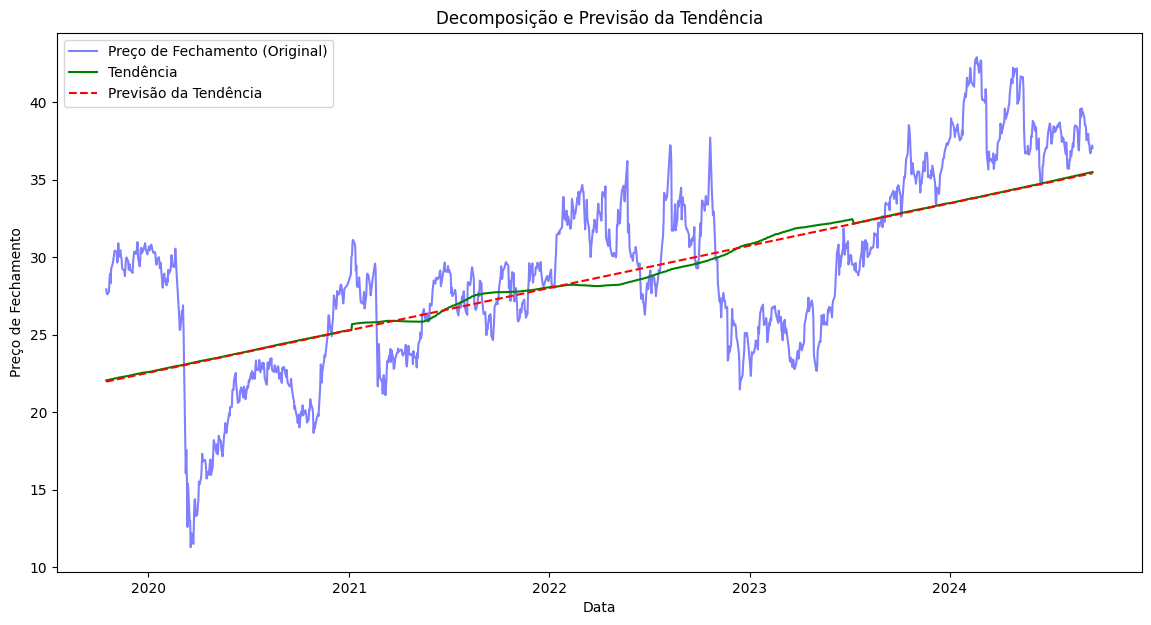

Inclinação da linha de tendência: 0.007479319173079232


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

df = df.reset_index()  # Isso move o índice (Date) para uma coluna chamada 'index' ou 'Date'

# Convertendo a coluna de data para o formato datetime, se necessário
df['Date'] = pd.to_datetime(df['Date'])
df['Date_ordinal'] = df['Date'].map(pd.Timestamp.toordinal)  # Converte a data para um número inteiro (ordinal)

# Definindo as variáveis de entrada e saída
X = df[['Date_ordinal']]  
y = df['Close'] 

# Decompondo a série temporal (usando '120' como o período da decomposição)
decomposition = seasonal_decompose(y, period=600, extrapolate_trend='freq')
trend = decomposition.trend.dropna()  # Extraímos a tendência e removemos valores nulos

# Ajustamos o X de acordo com os valores disponíveis após a decomposição
X_trend = X.loc[trend.index]  # Filtramos para que corresponda aos índices de 'trend'

# Criando e ajustando o modelo de regressão linear à tendência
linear_model = LinearRegression()
linear_model.fit(X_trend, trend)

# Prevendo os valores ajustados (a linha de tendência) sobre os dados de treino
y_pred = linear_model.predict(X_trend)

# Plotando os dados de tendência e a linha de tendência ajustada
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Preço de Fechamento (Original)', color='blue', alpha=0.5)
plt.plot(df.loc[trend.index, 'Date'], trend, label='Tendência', color='green')
plt.plot(df.loc[trend.index, 'Date'], y_pred, label='Previsão da Tendência', color='red', linestyle='--')
plt.title('Decomposição e Previsão da Tendência')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

# Mostrando a inclinação da linha de tendência
trend_slope = linear_model.coef_[0]
print(f"Inclinação da linha de tendência: {trend_slope}")

c:\Users\pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


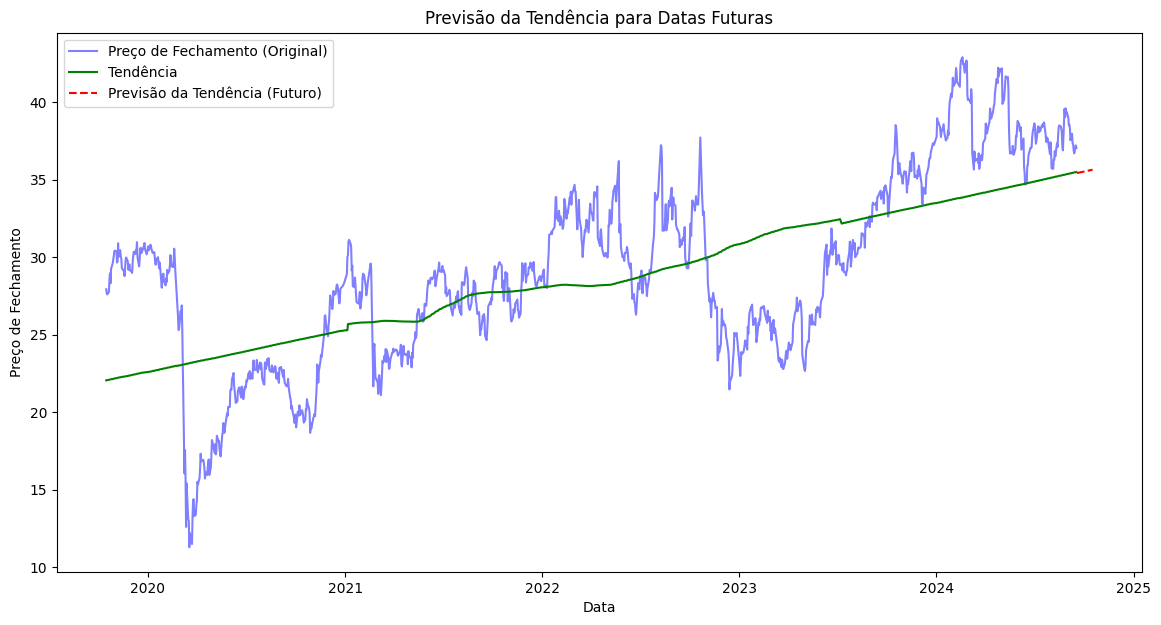

In [60]:
# --- Realizando previsões para datas futuras ---

# Definindo quantos dias no futuro você quer prever (por exemplo, 30 dias)
dias_futuros = 30
ultima_data = df['Date_ordinal'].max()

# Criando novas datas futuras no formato ordinal
datas_futuras = np.arange(ultima_data + 1, ultima_data + dias_futuros + 1).reshape(-1, 1)

# Realizando previsões para essas datas futuras
y_futuro_pred = linear_model.predict(datas_futuras)

# Convertendo as datas ordinais de volta para datetime
datas_futuras_datetime = pd.to_datetime([pd.Timestamp.fromordinal(int(d)) for d in datas_futuras])

# Plotando a previsão para os dias futuros
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Preço de Fechamento (Original)', color='blue', alpha=0.5)
plt.plot(df.loc[trend.index, 'Date'], trend, label='Tendência', color='green')
plt.plot(datas_futuras_datetime, y_futuro_pred, label='Previsão da Tendência (Futuro)', color='red', linestyle='--')
plt.title('Previsão da Tendência para Datas Futuras')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()


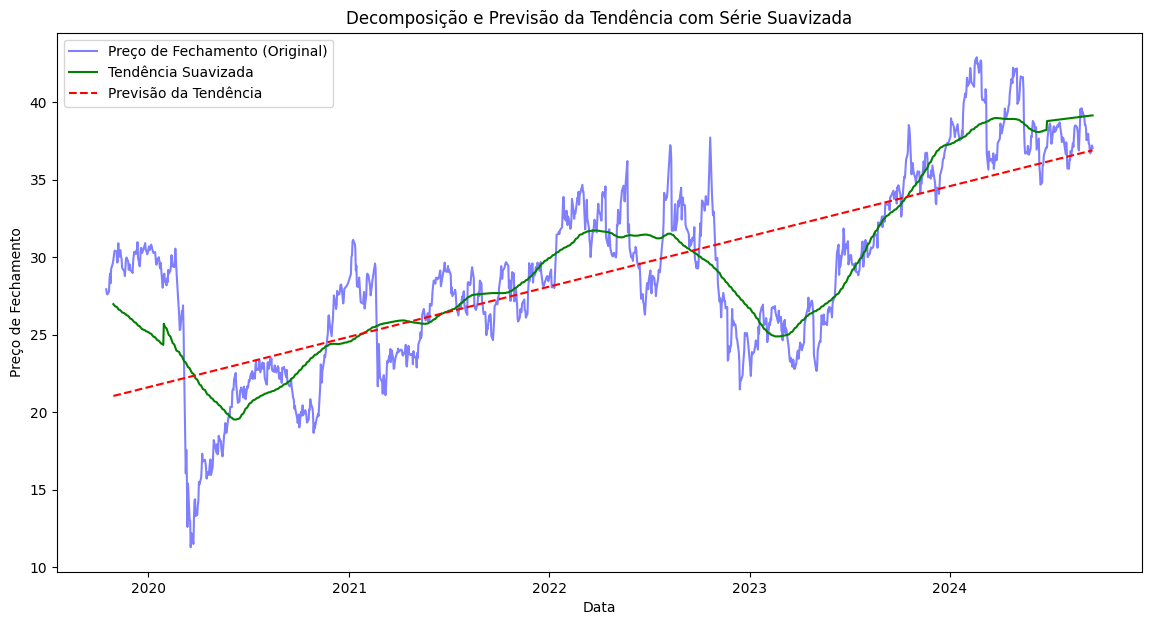

Inclinação da linha de tendência: 0.008877725987675443


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

# Resetando o índice para garantir que 'Date' está como coluna

# Convertendo a coluna de data para o formato datetime, se necessário
df['Date'] = pd.to_datetime(df['Date'])
df['Date_ordinal'] = df['Date'].map(pd.Timestamp.toordinal)  # Converte a data para um número inteiro (ordinal)

# Aplicando suavização por média móvel (remover ruído)
df['Close_smooth'] = df['Close'].rolling(window=10).mean()  # Suaviza com uma média móvel de 10 períodos

# Definindo as variáveis de entrada e saída (usamos a série suavizada)
X = df[['Date_ordinal']]  
y = df['Close_smooth']  # Usamos a série suavizada para remover ruído

# Decompondo a série suavizada (usando '120' como o período da decomposição)
decomposition = seasonal_decompose(y.dropna(), period=120, extrapolate_trend='freq')
trend = decomposition.trend.dropna()  # Extraímos a tendência e removemos valores nulos

# Ajustamos o X de acordo com os valores disponíveis após a decomposição
X_trend = X.loc[trend.index]  # Filtramos para que corresponda aos índices de 'trend'

# Criando e ajustando o modelo de regressão linear à tendência
linear_model = LinearRegression()
linear_model.fit(X_trend, trend)

# Prevendo os valores ajustados (a linha de tendência) sobre os dados de treino
y_pred = linear_model.predict(X_trend)

# Plotando os dados de tendência e a linha de tendência ajustada
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Preço de Fechamento (Original)', color='blue', alpha=0.5)
plt.plot(df.loc[trend.index, 'Date'], trend, label='Tendência Suavizada', color='green')
plt.plot(df.loc[trend.index, 'Date'], y_pred, label='Previsão da Tendência', color='red', linestyle='--')
plt.title('Decomposição e Previsão da Tendência com Série Suavizada')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

# Mostrando a inclinação da linha de tendência
trend_slope = linear_model.coef_[0]
print(f"Inclinação da linha de tendência: {trend_slope}")


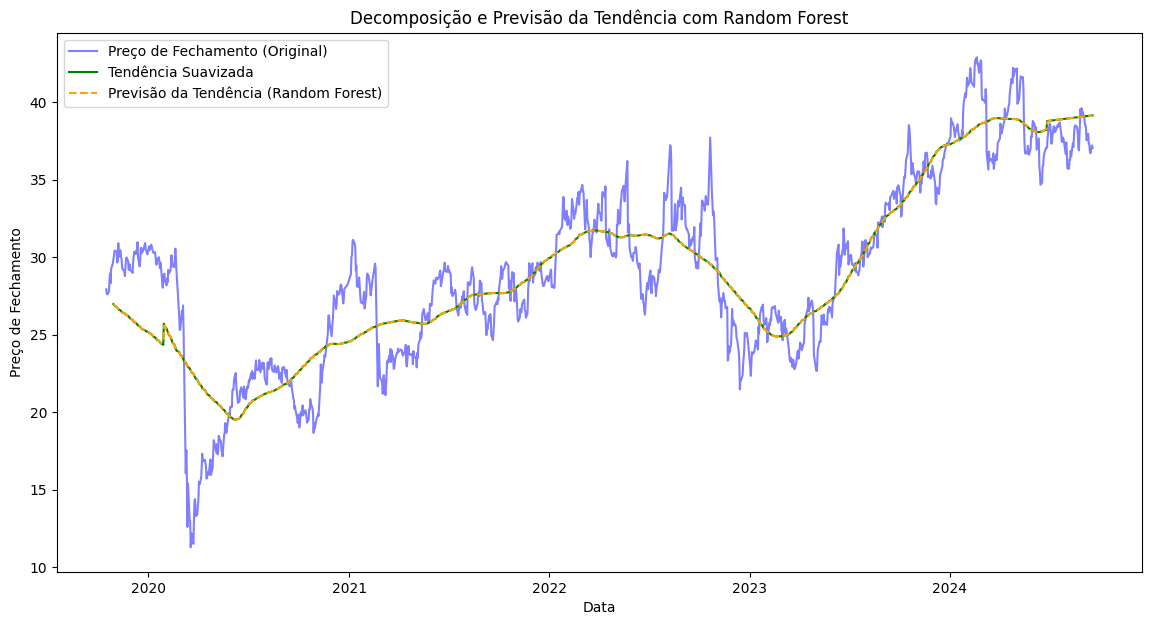

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

# Convertendo a coluna de data para o formato datetime, se necessário
df['Date'] = pd.to_datetime(df['Date'])
df['Date_ordinal'] = df['Date'].map(pd.Timestamp.toordinal)  # Converte a data para um número inteiro (ordinal)

# Aplicando suavização por média móvel (remover ruído)
df['Close_smooth'] = df['Close'].rolling(window=10).mean()  # Suaviza com uma média móvel de 10 períodos

# Definindo as variáveis de entrada e saída (usamos a série suavizada)
X = df[['Date_ordinal']]  
y = df['Close_smooth']  # Usamos a série suavizada para remover ruído

# Decompondo a série suavizada (usando '120' como o período da decomposição)
decomposition = seasonal_decompose(y.dropna(), period=120, extrapolate_trend='freq')
trend = decomposition.trend.dropna()  # Extraímos a tendência e removemos valores nulos

# Ajustamos o X de acordo com os valores disponíveis após a decomposição
X_trend = X.loc[trend.index]  # Filtramos para que corresponda aos índices de 'trend'

# Criando e ajustando o modelo Random Forest à tendência
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_trend, trend)

# Prevendo os valores ajustados (a linha de tendência) sobre os dados de treino
y_pred = random_forest_model.predict(X_trend)

# Plotando os dados de tendência e a linha de tendência ajustada
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Preço de Fechamento (Original)', color='blue', alpha=0.5)
plt.plot(df.loc[trend.index, 'Date'], trend, label='Tendência Suavizada', color='green')
plt.plot(df.loc[trend.index, 'Date'], y_pred, label='Previsão da Tendência (Random Forest)', color='orange', linestyle='--')
plt.title('Decomposição e Previsão da Tendência com Random Forest')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()
